In [21]:
import warnings
warnings.filterwarnings('ignore')

from tensorflow import keras
from keras.layers import Input, Lambda, Dense, Flatten, Dropout  # Added Dropout here
from keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report


In [22]:
# Define image size and paths

IMAGE_SIZE = [224, 224]
train_path = 'C:\\Users\\hp\\Desktop\\chest_xray\\chest_xray\\train'
valid_path = 'C:\\Users\\hp\\Desktop\\chest_xray\\chest_xray\\test'

In [ ]:
# Load the VGG16 model
vgg = VGG16(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)
for layer in vgg.layers:
    layer.trainable = False

# Create model structure
x = Flatten()(vgg.output)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)  # Dropout layer for regularization
x = Dense(64, activation='relu')(x)
x = Dropout(0.5)(x)
folders = os.listdir(train_path)  # List of classes (folders)

prediction = Dense(2, activation='softmax')(x)

model = Model(inputs=vgg.input, outputs=prediction)

In [25]:
# Compile the model with a lower learning rate
model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.Adam(learning_rate=0.0001), metrics=['accuracy'])

In [26]:
# Data Augmentation for Training Data
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    brightness_range=[0.8, 1.2]
)

train_set = train_datagen.flow_from_directory(
    train_path,
    target_size=(224, 224),
    batch_size=16,
    class_mode='categorical'
)

Found 5216 images belonging to 2 classes.


In [27]:
# Data Preprocessing for Test Data
test_datagen = ImageDataGenerator(rescale=1./255)
test_set = test_datagen.flow_from_directory(
    valid_path,
    target_size=(224, 224),
    batch_size=16,
    class_mode='categorical'
)

Found 624 images belonging to 2 classes.


In [28]:
history = model.fit(
    train_set,
    validation_data=test_set,
    epochs=15,
    steps_per_epoch=len(train_set),
    validation_steps=len(test_set)
)


Epoch 1/15
326/326 ━━━━━━━━━━━━━━━━━━━━ 494s 2s/step - accuracy: 0.7666 - loss: 0.4971 - val_accuracy: 0.8574 - val_loss: 0.3678
Epoch 2/15
326/326 ━━━━━━━━━━━━━━━━━━━━ 0s 170us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 3/15
326/326 ━━━━━━━━━━━━━━━━━━━━ 482s 1s/step - accuracy: 0.8729 - loss: 0.2961 - val_accuracy: 0.8798 - val_loss: 0.3075
Epoch 4/15
326/326 ━━━━━━━━━━━━━━━━━━━━ 0s 70us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 5/15
326/326 ━━━━━━━━━━━━━━━━━━━━ 440s 1s/step - accuracy: 0.8995 - loss: 0.2538 - val_accuracy: 0.8862 - val_loss: 0.3117
Epoch 6/15
326/326 ━━━━━━━━━━━━━━━━━━━━ 0s 43us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 7/15
326/326 ━━━━━━━━━━━━━━━━━━━━ 418s 1s/step - accuracy: 0.9040 - loss: 0.2383 - val_accuracy: 0.9022 - val_loss: 0.2681
Epoch 8/15
326/326 ━━━━━━━━━━━━━━━━━━━━ 0s 44us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 9/15
326/326 ━━━━━━━━━━━━━━━━━━━━ 425s 1s/step - accuracy: 0.9219 - loss: 0.2055 - val_accuracy: 

In [ ]:
# Check for Non-Image Files
def check_for_non_images(directory):
    for root, dirs, files in os.walk(directory):
        for file in files:
            if not file.lower().endswith(('.png', '.jpg', '.jpeg')):
                print(f"Non-image file found: {os.path.join(root, file)}")
                
check_for_non_images(train_path)
check_for_non_images(valid_path)

Non-image file found: C:\Users\hp\Desktop\chest_xray\chest_xray\train\.DS_Store
Non-image file found: C:\Users\hp\Desktop\chest_xray\chest_xray\train\NORMAL\.DS_Store
Non-image file found: C:\Users\hp\Desktop\chest_xray\chest_xray\train\PNEUMONIA\.DS_Store
Non-image file found: C:\Users\hp\Desktop\chest_xray\chest_xray\test\.DS_Store


In [30]:
model.save('chest_xray_.h5')

In [31]:
from tensorflow.keras.models import load_model
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

# Reload the model if needed
model = load_model('chest_xray_.h5')

In [33]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

test_datagen = ImageDataGenerator(rescale=1./255)
test_set = test_datagen.flow_from_directory(
    valid_path,
    target_size=(224, 224),
    batch_size=16,
    class_mode='categorical',
    shuffle=False  # Ensures order is preserved for true label alignment
)

Found 624 images belonging to 2 classes.


In [34]:
# Predict on the standardized test set
Y_pred = model.predict(test_set, verbose=1)
y_pred = np.argmax(Y_pred, axis=1)
y_true = test_set.classes

39/39 ━━━━━━━━━━━━━━━━━━━━ 44s 1s/step


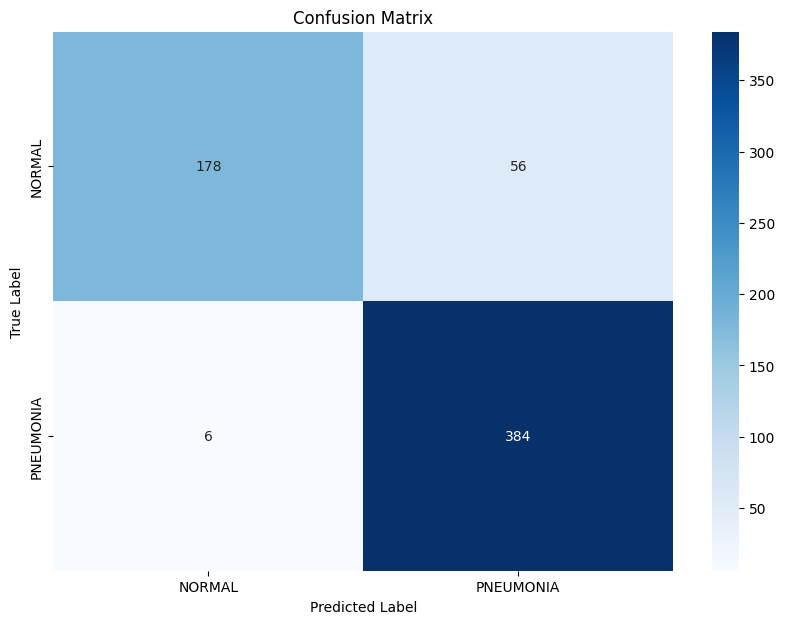

In [35]:
# Generate and display the confusion matrix

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=test_set.class_indices.keys(), 
            yticklabels=test_set.class_indices.keys())
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [37]:
# Print the classification report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=test_set.class_indices.keys()))

# Calculate and print the final accuracy percentage
final_accuracy = np.sum(y_pred == y_true) / len(y_true) * 100
print(f"\nFinal Accuracy on Test Set: {final_accuracy:.2f}%")

Classification Report:
              precision    recall  f1-score   support

      NORMAL       0.97      0.76      0.85       234
   PNEUMONIA       0.87      0.98      0.93       390

    accuracy                           0.90       624
   macro avg       0.92      0.87      0.89       624
weighted avg       0.91      0.90      0.90       624


Final Accuracy on Test Set: 90.06%


In [39]:
import numpy as np
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input

# Path to individual image files
img_paths = [
    'C:\\Users\\hp\\Desktop\\chest_xray\\chest_xray\\val\\NORMAL\\NORMAL2-IM-1427-0001.jpeg',
    r'C:\\Users\\hp\Desktop\\chest_xray\\chest_xray\\val\\PNEUMONIA\\person1946_bacteria_4874.jpeg'
]

In [40]:
# Iterate over each image path
for img_path in img_paths:
    # Load and preprocess image
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_data = preprocess_input(img_array)

    # Make a prediction
    prediction = model.predict(img_data)
    class_labels = ['NORMAL', 'PNEUMONIA']
    predicted_class = class_labels[np.argmax(prediction)]

    # Print the results for each image
    print(f'Predicted class for {img_path}: {predicted_class}')
    print(f'Prediction probabilities: {prediction}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 491ms/step
Predicted class for C:\Users\hp\Desktop\chest_xray\chest_xray\val\NORMAL\NORMAL2-IM-1427-0001.jpeg: NORMAL
Prediction probabilities: [[1. 0.]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step
Predicted class for C:\\Users\\hp\Desktop\\chest_xray\\chest_xray\\val\\PNEUMONIA\\person1946_bacteria_4874.jpeg: PNEUMONIA
Prediction probabilities: [[0. 1.]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


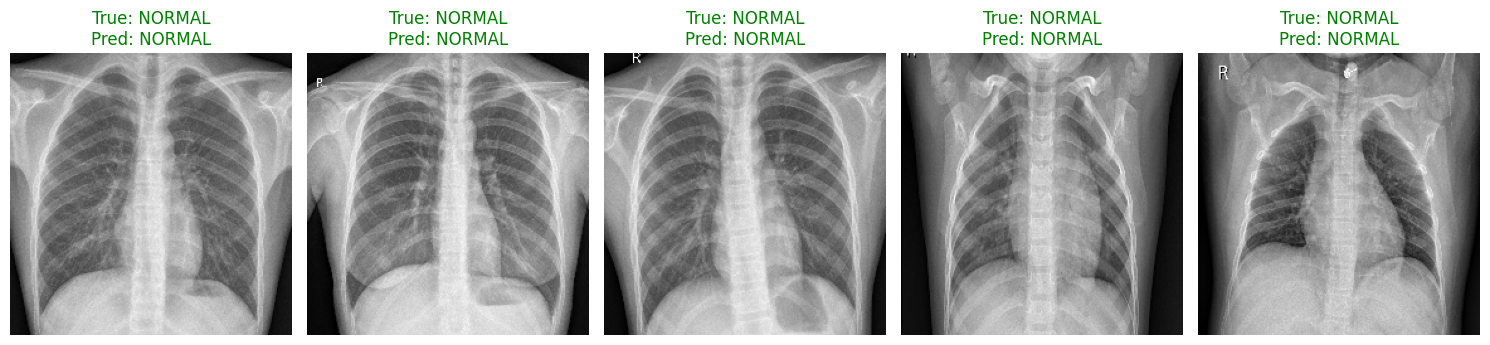

In [45]:
import numpy as np
import matplotlib.pyplot as plt

# Display sample predictions with enhanced visuals
def plot_sample_predictions(test_set, model, num_samples=5):
    plt.figure(figsize=(15, 10))
    
    # Get a batch of images and true labels
    images, true_labels = next(iter(test_set))
    predictions = model.predict(images)
    pred_labels = np.argmax(predictions, axis=1)
    class_labels = list(test_set.class_indices.keys())
    
    # Extract integer class indices from true_labels if it's one-hot encoded
    if len(true_labels.shape) > 1:  # Check if labels are one-hot encoded
        true_labels = np.argmax(true_labels, axis=1)
    
    # Plot the first `num_samples` images
    for i in range(num_samples):
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(images[i])
        
        # Retrieve true and predicted class labels
        true_class = class_labels[true_labels[i]]
        predicted_class = class_labels[pred_labels[i]]
        
        # Color title based on prediction accuracy
        color = "green" if true_class == predicted_class else "red"
        plt.title(f"True: {true_class}\nPred: {predicted_class}", color=color)
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Call the function
plot_sample_predictions(test_set, model)
